In [2]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [3]:
include(string(@__DIR__, "/../Scripts/jupic.jl"))

using Random
using Plots
using ProgressMeter


In [20]:
"""
    make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
"""
function make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
    seq_len = mean_distance_btw_markers * marker_char_count
    char_list = rand(random_char_pool, seq_len)
    marker_idxs = Random.randperm(seq_len)[1:marker_char_count]
    for i in marker_idxs
        char_list[i] = marker_char
    end
    seq = join(char_list)
    return seq
end

"""
    encode(seq)
"""
function encode(seq, encoding_size)
    unique_letters = Set([s for s in seq])
    encodings = Dict{Char, Array{Int, 1}}()
    for ul in unique_letters
        encodings[ul] = randperm(num_cols)[1:encoding_size]
    end
    return encodings
end

"""
    train!(tm, encodings, seq, epochs)
"""
function train!(tm, encodings, seq, epochs)
    for i in 1:epochs
        for char in seq
            update!(tm, encodings[char])
        end
    end
end

"""
    marker_representations(tm, encodings, seq, marker_char)
"""
function marker_representations(tm, encodings, seq, marker_char)
    cell_reps = Array{Int, 1}[]
    col_reps = Array{Int, 1}[]
    for char in seq
        update!(tm, encodings[char])
        if char == marker_char
            push!(cell_reps, predicted_cells(tm))
            push!(col_reps, predicted_columns(tm))
        end
    end

    return cell_reps, col_reps
end

overlap(x::Array{Int, 1}, y::Array{Int, 1}) = length(intersect(x, y))

"""
    pairwise_overlap_matrix(true_col_encoding, cell_reps, col_reps, accuracy_threshold=0.5)
"""
function pairwise_overlap_matrix(true_col_encoding, cell_reps, col_reps, overlap_threshold=4)

    num_marker_chars = length(cell_reps)
    R = zeros(num_marker_chars, num_marker_chars)

    for (i, cell_rep_i) in enumerate(cell_reps)
        for (j, cell_rep_j) in enumerate(cell_reps)
            if overlap(col_reps[i], true_col_encoding) < overlap_threshold
                R[i, j] = NaN
            else
                R[i, j] = overlap(cell_rep_i, cell_rep_j)
            end
        end
    end

    return R
end

function flatten_and_hcat(X)
    flats = map(x -> reshape(x, :), X)
    stacked = hcat(flats...)
end

flatten_and_hcat (generic function with 1 method)

In [8]:
num_cols = 128
cells_per_col = 16
synapse_sample_size = 32
encoding_size = 8
random_char_pool_size = 25
marker_char_count = 10
mean_distance_btw_markers = 5



tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = synapse_sample_size,
    initial_segments_per_cell = 0,
    initial_permanence = 0.495,
)

marker_char = 'A'
random_char_pool = collect('B':'z')[1:random_char_pool_size]
seq = make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
encodings = encode(seq, encoding_size)

overlap_matrices = []
epochs_per_iter = 1
num_matrices = 50
@showprogress for i in 1:num_matrices
    train!(tm, encodings, seq, epochs_per_iter)
    col_reps, cell_reps = marker_representations(tm, encodings, seq, marker_char)
    push!(overlap_matrices, pairwise_overlap_matrix(encodings[marker_char], cell_reps, col_reps))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:36


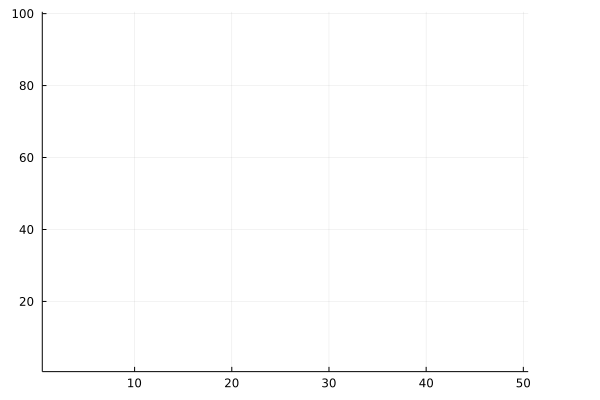

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [9]:
overlap_through_training = flatten_and_hcat(overlap_matrices)
max_overlap = maximum(overlap_through_training)
overlap_through_training[isnan.(overlap_through_training)] .= -max_overlap

normalized_matrix = overlap_through_training ./ max_overlap
heatmap(
    normalized_matrix,
    c = cgrad([:orange, :green])
)





In [42]:
sum(isnan.(overlap_through_training))

5000

In [18]:
println("Synapse density: $(num_synapses(tm, 1:tm.ps.num_cols) / length(tm.cells) ^ 2)")

Synapse density: 0.15358352661132812


I think we need to refresh the state each time, and then introduce a start character with no segments from other cells

Or maybe all we need is the same initial condition every time.

What do we need?

`encoding_len` active and winner cells

No, those get computed.

We need an initial set of random segments

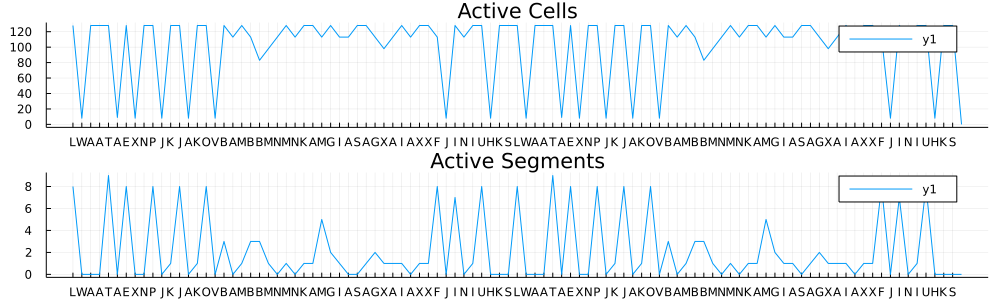

In [40]:
num_active_cells = length.([tm.active_cells[t] for t in 1:tm.t])
active_segments = length.([tm.active_segments[t] for t in 1:tm.t])

p1 = plot(size=(1000, 300), title="Active Cells")
plot!(num_active_cells[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

p2 = plot(size=(1000, 300), title="Active Segments")
plot!(active_segments[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

plot(p1, p2, layout=@layout [a ; b])

## Try again with a refresh in between

In [43]:
num_cols = 128
cells_per_col = 16
synapse_sample_size = 32
encoding_size = 8
random_char_pool_size = 25
marker_char_count = 10
mean_distance_btw_markers = 5



tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = synapse_sample_size,
    initial_segments_per_cell = 0,
    initial_permanence = 0.495,
)

marker_char = 'A'
random_char_pool = collect('B':'z')[1:random_char_pool_size]
seq = make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
encodings = encode(seq, encoding_size)

overlap_matrices = []
epochs_per_iter = 1
num_matrices = 50
@showprogress for i in 1:num_matrices
    train!(tm, encodings, seq, epochs_per_iter)
    col_reps, cell_reps = marker_representations(tm, encodings, seq, marker_char)
    push!(overlap_matrices, pairwise_overlap_matrix(encodings[marker_char], cell_reps, col_reps))
    # REFRESH
    update!(tm, Int[])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:07


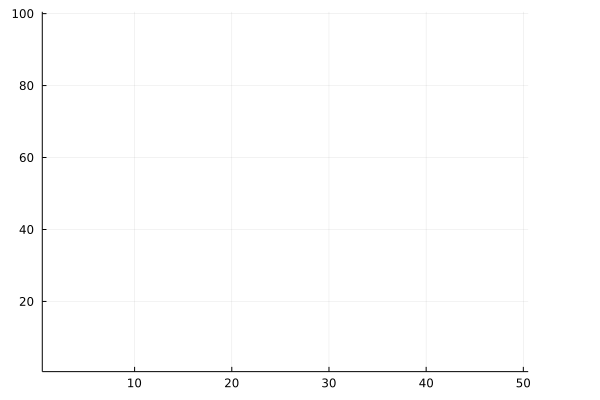

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [44]:
overlap_through_training = flatten_and_hcat(overlap_matrices)
max_overlap = maximum(overlap_through_training)
overlap_through_training[isnan.(overlap_through_training)] .= -max_overlap

normalized_matrix = overlap_through_training ./ max_overlap
heatmap(
    normalized_matrix,
    c = cgrad([:orange, :green])
)





In [45]:
sum(isnan.(overlap_through_training))

5000

In [46]:
println("Synapse density: $(num_synapses(tm, 1:tm.ps.num_cols) / length(tm.cells) ^ 2)")

Synapse density: 0.1523144245147705


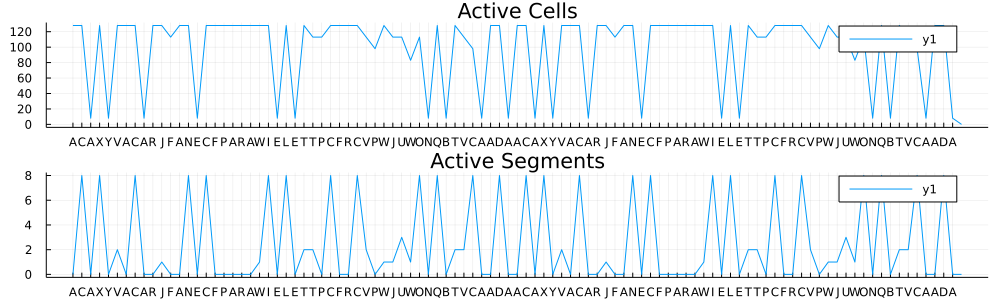

In [47]:
num_active_cells = length.([tm.active_cells[t] for t in 1:tm.t])
active_segments = length.([tm.active_segments[t] for t in 1:tm.t])

p1 = plot(size=(1000, 300), title="Active Cells")
plot!(num_active_cells[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

p2 = plot(size=(1000, 300), title="Active Segments")
plot!(active_segments[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

plot(p1, p2, layout=@layout [a ; b])

### Run the experiment with an initial condition of active and winner cells.

In [12]:
function set_initial!(tm::TempMem, init_cells::Array{Cell{T}, 1}) where T
    for c in init_cells
        push!(tm.active_cells[tm.t], c)
        push!(tm.winner_cells[tm.t], c)
    end
end

set_initial! (generic function with 2 methods)

In [13]:
num_cols = 128
cells_per_col = 16
synapse_sample_size = 32
encoding_size = 8
random_char_pool_size = 25
marker_char_count = 10
mean_distance_btw_markers = 5



tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = synapse_sample_size,
    initial_segments_per_cell = 0,
    initial_permanence = 0.495,
)

marker_char = 'A'
random_char_pool = collect('B':'z')[1:random_char_pool_size]
seq = make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
encodings = encode(seq, encoding_size)

# Initial condition
init_active = rand(tm.cells, encoding_size)
set_initial!(tm, init_active)

overlap_matrices = []
epochs_per_iter = 1
num_matrices = 50
@showprogress for i in 1:num_matrices
    train!(tm, encodings, seq, epochs_per_iter)
    col_reps, cell_reps = marker_representations(tm, encodings, seq, marker_char)
    push!(overlap_matrices, pairwise_overlap_matrix(encodings[marker_char], cell_reps, col_reps))
    # REFRESH
    update!(tm, Int[])
    # SET INITIAL CONDITION
    set_initial!(tm, init_active)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:14


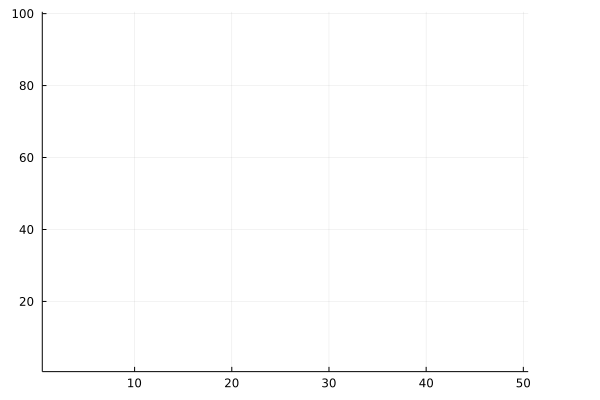

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [21]:
overlap_through_training = flatten_and_hcat(overlap_matrices)
max_overlap = maximum(overlap_through_training)
overlap_through_training[isnan.(overlap_through_training)] .= -max_overlap

normalized_matrix = overlap_through_training ./ max_overlap
heatmap(
    normalized_matrix,
    c = cgrad([:orange, :green])
)





In [22]:
sum(isnan.(overlap_through_training))

5000

In [23]:
println("Synapse density: $(num_synapses(tm, 1:tm.ps.num_cols) / length(tm.cells) ^ 2)")

Synapse density: 0.13999223709106445


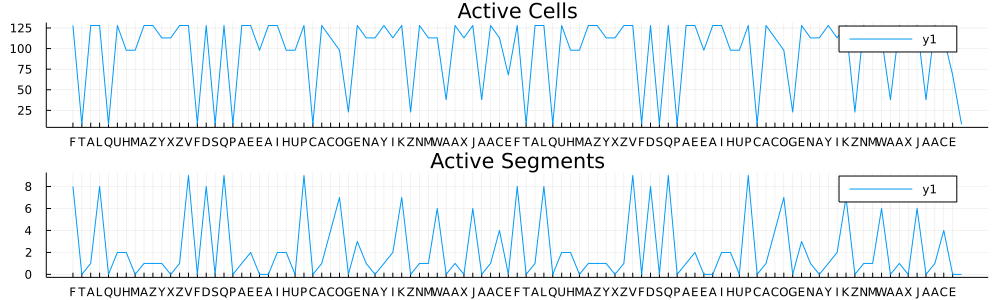

In [24]:
num_active_cells = length.([tm.active_cells[t] for t in 1:tm.t])
active_segments = length.([tm.active_segments[t] for t in 1:tm.t])

p1 = plot(size=(1000, 300), title="Active Cells")
plot!(num_active_cells[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

p2 = plot(size=(1000, 300), title="Active Segments")
plot!(active_segments[end-100:end])
xticks!(1:100, [string(s) for s in seq*seq])

plot(p1, p2, layout=@layout [a ; b])

# More tests

In [31]:
num_cols = 128
cells_per_col = 16
synapse_sample_size = 32
encoding_size = 8
random_char_pool_size = 25
marker_char_count = 10
mean_distance_btw_markers = 5



tm = TempMem(
    num_cols, 
    cells_per_col,
    synapse_sample_size = synapse_sample_size,
    initial_segments_per_cell = 0,
    initial_permanence = 0.495,
)

marker_char = 'A'
random_char_pool = collect('B':'z')[1:random_char_pool_size]
seq = make_marker_seq(marker_char, marker_char_count, mean_distance_btw_markers, random_char_pool)
encodings = encode(seq, encoding_size);

# Initial condition
init_active = rand(tm.cells, encoding_size)
set_initial!(tm, init_active)

overlap_matrices = []
tot_synapse = []
epochs_per_iter = 1
num_matrices = 50
@showprogress for i in 1:num_matrices
    train!(tm, encodings, seq, epochs_per_iter)
    col_reps, cell_reps = marker_representations(tm, encodings, seq, marker_char)
    push!(overlap_matrices, pairwise_overlap_matrix(encodings[marker_char], cell_reps, col_reps))
    # REFRESH
    update!(tm, Int[])
    # SET INITIAL CONDITION
    set_initial!(tm, init_active)
    push!(tot_synapse, num_synapses(tm, 1:tm.ps.num_cols))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:24


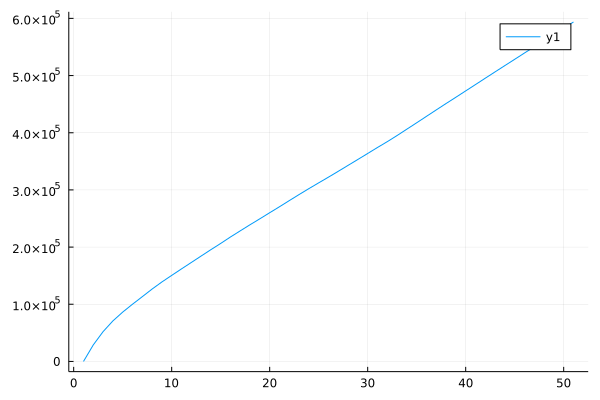

In [35]:
plot(append!([0], tot_synapse))

1-element Vector{Int64}:
 2